# Clickstream data propensity model 

In [2]:
import pandas as pd
import numpy as np 
from toggle_cell import toggle_code as hide_sloution

## Investigation of structure, quality and content

1. **Structure investigation**: Exploring the general shape of the dataset, as well as the data types of data features.
2. **Quality investigation**: Get a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.
3. **Content investigation**: Once the structure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the features values and look at how different features relate to each other.

But first we need to find an interesting dataset. Let's go ahead and load the "DVMWare Data"

In [2]:
df_train=pd.read_csv('IMB_621_VMW_SERVER_CASE_DATA.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (444,445,446,447,450,451,452,453,455,456,457,458,461,463,464,465,466,474,475,476,477,480,481,482,483,485,486,487,488,491,493,494,495,496,785) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_val=pd.read_csv('VMWare Validation Dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (444,445,446,447,450,451,452,453,455,456,458,461,463,464,465,468,470,474,475,476,477,480,481,482,483,485,486,488,491,493,494,495,498,500,770) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Structure Investigation

Before looking at the content of our feature matrix $X$, let's first look at the general structure of the dataset. For example, how many columns and rows does the dataset have?

In [4]:
df_train.shape,df_val.shape

((100000, 958), (49999, 958))

So we know that this dataset has 100000 samples and 958 features. And how many different data types do these 958 features contain?

In [5]:
pd.value_counts(df_train.dtypes)

float64    590
int64      268
object     100
dtype: int64

Looking at the data, we now know there are partially encoded columns like Board_CBSE, Board_ICSE of Board_SSC categorical variable also Degree_Engg from the Course_Degree categorical variable, missing out proper encoding of all the category types of a feature. Which we need to drop and encode them with one hot encoding correctly. 

</t>Also there are Encoded columns for gender and placement with Gender-B and Placement-B, of which the categorical features can be dropped.

## 1.1. Structure of non-numerical features

Data types can be numerical and non-numerical. First, let's take a closer look at the **non-numerical** entries.

In [6]:
# Display non-numerical features
df_train.select_dtypes(exclude="number").head()

,flag,db_industry,db_city,db_companyname,db_country,db_employeerange,db_accountwatch,db_audience,db_subindustry,prodA_launch_date,...,idc_verticals,citdb_ent_it_emple,citdb_ent_server,citdb_ent_it_budget,citdb_ent_hardware_budget,load_timestamp,hyperthreading_active_flag,hv_replay_capable_flag,record_type,prodV_booking_pct
0,t,Unknown,Stadthagen,Unitymedia,DE,NaN,NaN,Residential,NaN,1/1/2008,...,Unknown,NaN,Unknown,Unknown,NaN,6/23/2016 5:00,Y,Y,Unknown,0.5
1,t,Unknown,Kimitsu,"FreeBit Co.,Ltd.",JP,NaN,NaN,SMB,NaN,1/1/2008,...,Unknown,NaN,Unknown,Unknown,NaN,6/23/2016 5:00,Y,Y,Unknown,0.5
2,t,Unknown,Kuala Lumpur,"Tmnet, Telekom Malaysia Bhd.",MY,NaN,NaN,SOHO,NaN,1/1/2008,...,Unknown,NaN,Unknown,Unknown,NaN,6/23/2016 5:00,Y,Y,Unknown,0
3,t,Unknown,Valmadrera,Telecom Italia,IT,NaN,NaN,Residential,NaN,1/1/2008,...,Other,NaN,Unknown,Unknown,NaN,6/23/2016 5:00,NaN,NaN,PERSON,0
4,t,Unknown,Cardiff,NaN,GB,NaN,NaN,Residential,NaN,1/1/2008,...,Services,NaN,Unknown,Unknown,NaN,6/23/2016 5:00,NaN,NaN,PERSON,0


Using the `.describe()` function we can also investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [7]:
df_train.describe(exclude="number")

,flag,db_industry,db_city,db_companyname,db_country,db_employeerange,db_accountwatch,db_audience,db_subindustry,prodA_launch_date,...,idc_verticals,citdb_ent_it_emple,citdb_ent_server,citdb_ent_it_budget,citdb_ent_hardware_budget,load_timestamp,hyperthreading_active_flag,hv_replay_capable_flag,record_type,prodV_booking_pct
count,100000,100000,75493,59703,82224,21070,845,85948,23018,100000,...,100000,5606,100000,100000,5606,100000,61707,61707,100000,97421.0
unique,1,33,12143,18352,175,6,348,122,170,1,...,14,8,8,8,7,1,2,2,3,9315.0
top,t,Unknown,Tokyo,Comcast Cable,US,Very Small,null:null:null:null,Residential,Software Applications,1/1/2008,...,Unknown,<250,Unknown,Unknown,<$5 million,6/23/2016 5:00,Y,Y,Unknown,0.0
freq,100000,76982,2684,3000,39408,9397,295,42813,2359,100000,...,61883,3551,94398,94398,4270,100000,61484,61654,60802,68746.0


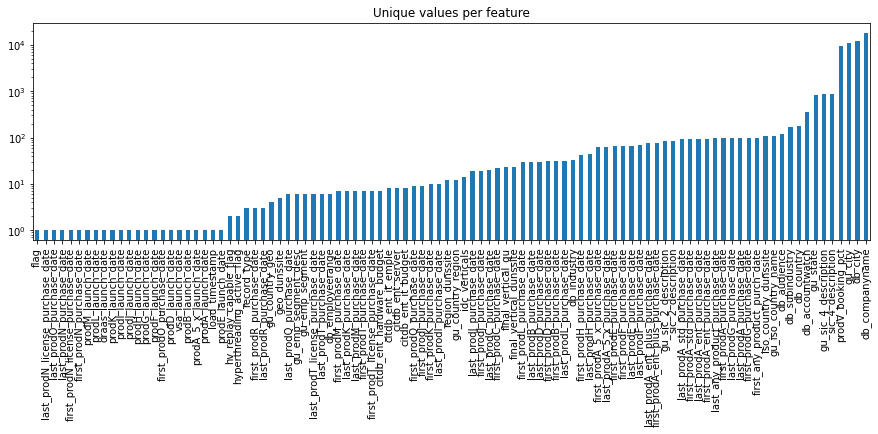

In [20]:
# For each numerical feature compute number of unique entries
unique_values = df_train.select_dtypes(
  exclude="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

## 1.2. Structure of numerical features

Next, let's take a closer look at the numerical features. More precisely, let's investigate how many unique values each of these feature has. This process will give us some insights about the number of **binary** (2 unique values), **ordinal** (3 to ~10 unique values) and **continuous** (more than 10 unique values) features in the dataset.

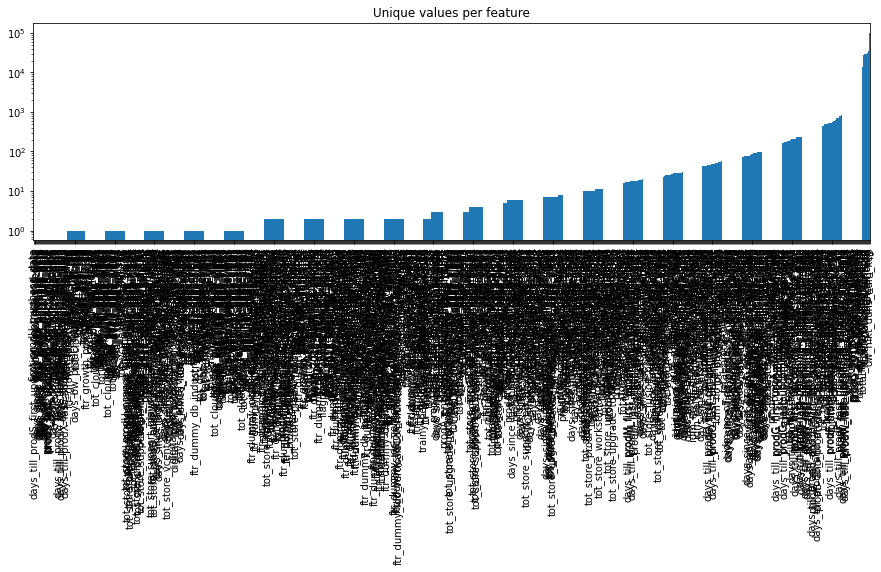

In [22]:
# For each numerical feature compute number of unique entries
unique_values = df_train.select_dtypes(
  include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

## 1.3. Conclusion of structure investigation

At the end of this first investigation, we have a better understanding of the general structure of our dataset. Number of samples and features, what kind of data type each feature has, and how many of them are binary, ordinal, categorical or continuous. 

# 2. Quality Investigation

Before focusing on the actual content stored in these features, let's first take a look at the general quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors.

But first let us find our Y (Response variable) 

In [8]:
df_train.filter(regex='workstation|Workstation').columns

Index(['tot_store_workstation_pro_product_page_views',
       'tot_store_workstation_player_product_page_views',
       'tot_store_upgrade_to_workstation_pro_page_views',
       'tot_store_upgrade_to_workstation_player_page_views',
       'tot_store_support_pis_workstation_pro_page_views',
       'tot_store_support_pis_workstation_player_page_views',
       'num_workstation_campaign_responses',
       'digital_num_workstation_webcast_responses',
       'num_workstation_seminar_responses',
       'digital_workstation_paid_search_responses',
       'digital_workstation_online_responses',
       'digital_workstation_eval_responses', 'num_workstation_responses',
       'num_workstation_campaign_network_role_responses',
       'trainy_period_workstation_purchase_flag'],
      dtype='object')

In [9]:
df_train.filter(regex='Purchase|purchase').columns

Index(['purchase_events', 'first_prodA_purchase_date',
       'first_prodA_5_x_purchase_date', 'first_prodB_purchase_date',
       'first_prodC_purchase_date', 'first_prodD_purchase_date',
       'first_prodE_purchase_date', 'first_prodF_purchase_date',
       'first_prodG_purchase_date', 'first_prodH_purchase_date',
       ...
       'days_since_first_prodA_ent_plus_purchase_date',
       'days_since_first_prodU_purchase_date',
       'days_since_last_prodT_purchase_date',
       'days_since_last_prodT_license_purchase_date',
       'days_since_last_prodN_license_purchase_date',
       'days_since_last_prodA_std_purchase_date',
       'days_since_last_prodA_ent_purchase_date',
       'days_since_last_prodA_ent_plus_purchase_date',
       'days_since_last_prodU_purchase_date',
       'trainy_period_workstation_purchase_flag'],
      dtype='object', length=121)

We have trainy_period_workstation_purchase_flag which sounds like the variable that is encoded with {1,0}, with 0 as not_purchased during the period and 1 as purchased workstation during the period

In [11]:
df_train.trainy_period_workstation_purchase_flag.value_counts(normalize=True)*100

0    96.5
1     3.5
Name: trainy_period_workstation_purchase_flag, dtype: float64

only 3.5% of purchases of workstation in the data

**The Dependant variable for our prediction will be**

In [5]:
response_variable ='trainy_period_workstation_purchase_flag'

From the above query we can observe no missing records in the response variable 

In [13]:
print(f'The Class imbalance ratio is : {df_train.trainy_period_workstation_purchase_flag.value_counts().max()/df_train.trainy_period_workstation_purchase_flag.value_counts().min()}')

The Class imbalance ratio is : 27.571428571428573


<div class="alert alert-block alert-danger" >
The **High-Imbalance ratio** which is way greater than 4 is a clear indicator of applying imbalance remedy to build correct model. 

## 2.1. Duplicates

Duplicates are entries that represent the same sample point multiple times. For example, if a measurement was registered twice by two different people. Detecting such duplicates is not always easy, as each dataset might have a unique identifier (e.g. an index number or recording time that is unique to each new sample) which you might want to ignore first.

In [5]:
# Check number of duplicates while ignoring the dependant feature
n_duplicates = df_train.drop(labels=[response_variable], axis=1).duplicated().sum()
print(f"We have {n_duplicates} duplicates in the database.")

#  Extract column names of all features, except 'Placement_B'
columns_to_consider = df_train.drop(labels=[response_variable], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_train.drop_duplicates(subset=columns_to_consider)
df_X.shape



We have 0 duplicates in the database.


(100000, 958)

## 2.2. Missing values

Another quality issue worth to investigate are missing values. Having some missing values is normal. What we want to identify at this stage are big holes in the dataset, i.e. samples or features with a lot of missing values.

### 2.2.1. Dropping colums which doesnt have 80% of the records

To look at number of missing values per sample we have multiple options. The most straight forward one is to simply visualize the output of `df_X.isna()`, with something like this:

In [6]:
# Atleast 80% rows per features
row_threshold = 0.8
num_rows = np.ceil(df_train.shape[0]*row_threshold)
num_rows
df_train.dropna(thresh=num_rows, axis=1,inplace=True)

In [7]:
df_train.shape

(100000, 476)

after dropping columns with a threshold of 75% of rows to be filled in the feature, now we have 476 features we can analyse on.

In [8]:
'''
Applying Threshold -- Need to have atleast this number 
thresh --> Require that many non-NA values.
'''
# Atleast 75% features per row
col_threshold = 1
num_cols = np.ceil(df_train.shape[1]*col_threshold)
num_cols
df_train.dropna(thresh=num_cols,inplace=True)

In [9]:
df_train.shape

(77493, 476)

In [10]:
final_features = df_train.columns.to_list()

In [11]:
df_val=df_val[final_features]

In [12]:
df_val.shape

(49999, 476)

In [13]:
'''
Applying Threshold -- Need to have atleast this number 
thresh --> Require that many non-NA values.
'''

# Atleast 75% features per row
col_threshold = 1
num_cols = np.ceil(df_val.shape[1]*col_threshold)
num_cols
df_val.dropna(thresh=num_cols,inplace=True)

In [14]:
df_val.shape

(37850, 476)

we choose to drop any row with missing value and finally we have 77493 records with 476 features

In [3]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
hide_sloution()

In [17]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values

Your selected dataframe has 476 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [18]:
### run from this after dropping missing value columns

In [16]:
#df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].fillna(-1) 
df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].replace('#NAME?',np.nan)
df_train['prodV_booking_pct']=df_train['prodV_booking_pct'].apply(lambda x: x.astype(float) if x==str else x)
df_train['prodV_booking_pct']=df_train[['prodV_booking_pct']].astype(float)

In [17]:
#df_val['prodV_booking_pct']=df_val['prodV_booking_pct'].fillna(-1) 
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,'prodV_booking_pct'].replace('#NAME?',np.nan)
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,'prodV_booking_pct'].apply(lambda x: x.astype(float) if x==str else x)
df_val.loc[:,'prodV_booking_pct']=df_val.loc[:,['prodV_booking_pct']].astype(float)

cleaning up errors such as '#Name?' 

In [18]:
df_val[['prodV_booking_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37850 entries, 0 to 49998
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prodV_booking_pct  37850 non-null  float64
dtypes: float64(1)
memory usage: 591.4 KB


In [19]:
category_list = list(df_train.select_dtypes(include='object'))

#category_list.pop(category_list.index('db_country'))
category_list

['flag',
 'db_industry',
 'db_country',
 'db_audience',
 'prodA_launch_date',
 'prodA_5_x_launch_date',
 'prodB_launch_date',
 'vsa_launch_date',
 'prodD_launch_date',
 'prodE_launch_date',
 'prodF_launch_date',
 'prodG_launch_date',
 'prodH_launch_date',
 'prodJ_launch_date',
 'prodI_launch_date',
 'prodK_launch_date',
 'draas_launch_date',
 'prodL_launch_date',
 'prodM_launch_date',
 'first_any_product_purch_date',
 'first_prodG_purchase_date',
 'last_any_product_purchase_date',
 'last_prodG_purchase_date',
 'geo_dunssite',
 'gu_emp_segment_desc',
 'idc_verticals',
 'citdb_ent_server',
 'citdb_ent_it_budget',
 'load_timestamp',
 'record_type']

here we can observe datetime colums as object type, conveting them back to datetime objects so we can have time based sampling, according to strategy.

In [20]:
find_date_ls =['first_any_product_purch_date',
 'first_prodG_purchase_date',
 'last_any_product_purchase_date',
 'last_prodG_purchase_date',]

In [27]:
df_train.shape

(77493, 476)

In [21]:
df_train.filter(regex='date|Date').columns

Index(['prodA_launch_date', 'prodA_5_x_launch_date', 'prodB_launch_date',
       'vsa_launch_date', 'prodD_launch_date', 'prodE_launch_date',
       'prodF_launch_date', 'prodG_launch_date', 'prodH_launch_date',
       'prodJ_launch_date', 'prodI_launch_date', 'prodK_launch_date',
       'draas_launch_date', 'prodL_launch_date', 'prodM_launch_date',
       'first_any_product_purch_date', 'first_prodG_purchase_date',
       'last_any_product_purchase_date', 'last_prodG_purchase_date',
       'days_since_first_prodG_purchase_date',
       'days_since_last_prodG_purchase_date'],
      dtype='object')

In [22]:
df_train[find_date_ls]=df_train[find_date_ls].apply(pd.to_datetime)
df_val[find_date_ls]=df_val[find_date_ls].apply(pd.to_datetime)

In [23]:
_={}
for col in find_date_ls:
    _[col]=(min(df_train[col]),max(df_train[col])) 

In [24]:
_

{'first_any_product_purch_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'first_prodG_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'last_any_product_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00')),
 'last_prodG_purchase_date': (Timestamp('2008-01-01 00:00:00'),
  Timestamp('2015-12-01 00:00:00'))}

`The dates from training data ranges from 2008-01-01 to 2015-12-01`

`the dates at validation date is ranging from 2008-01-01 toi 2016-03-01`

<div class="alert alert-block alert-danger" >
For training, we will use aggregate data up to September 2015 and predict the Workstation buyers durg October–December 2015.

In [25]:
X_train=df_train[df_train['last_any_product_purchase_date']<='2015-09-01'].loc[:,df_train.columns!=response_variable]
y_train = df_train[df_train['last_any_product_purchase_date']<='2015-09-01'].loc[:,response_variable]
X_test=df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_test = df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,response_variable]

<div class="alert alert-block alert-danger" >
For vlidation use aggregate data till 2015 december and predict on purchases during Jan 2016 to march 2016

In [26]:
X_val=df_train.drop(response_variable,axis=1)
y_val=df_train[response_variable]
X_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,df_val.columns!=response_variable]
y_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,response_variable]


<div class="alert alert-block alert-danger" >
for scoring we will be using aggregated data till March 2016

In [27]:
X_score=df_val.drop(response_variable,axis=1)
y_score=df_val[response_variable]

shapes

In [55]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 475), (11841, 475), (77493, 475), (2589, 475), (37850, 475))

In [56]:
y_train.shape,y_test.shape,y_val.shape,y_val_test.shape,y_score.shape

((65652,), (11841,), (77493,), (2589,), (37850,))

### Encoding the date columns

In [29]:
X_train.drop(find_date_ls,axis=1,inplace=True)
X_test.drop(find_date_ls,axis=1,inplace=True)
X_val.drop(find_date_ls,axis=1,inplace=True)
X_val_test.drop(find_date_ls,axis=1,inplace=True)
X_score.drop(find_date_ls,axis=1,inplace=True)

In [30]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [31]:
X_val.loc[:,'channel_direct_total_pct']=X_val.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_val['channel_direct_total_pct']=X_val['channel_direct_total_pct'].astype(float)
X_val_test.loc[:,'channel_direct_total_pct']=X_val_test.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_val_test['channel_direct_total_pct']=X_val_test['channel_direct_total_pct'].astype(float)
X_score.loc[:,'channel_direct_total_pct']=X_score.loc[:,'channel_direct_total_pct'].replace('#NAME?',np.nan)
X_score['channel_direct_total_pct']=X_score['channel_direct_total_pct'].astype(float)

In [32]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [33]:
category_list_train = list(X_train.select_dtypes(include='object'))
category_list_val = list(X_val.select_dtypes(include='object'))
#category_list.pop(category_list.index('db_country'))
set(category_list_val)-set(category_list_train)
category_list_train==category_list_val

True

In [34]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

**Encoding**

In [35]:
from sklearn.preprocessing import OrdinalEncoder

In [36]:
enc = OrdinalEncoder()
X_train[category_list_train] = enc.fit_transform(X_train[category_list_train])
X_test[category_list_train] = enc.fit_transform(X_test[category_list_train])
X_val[category_list_val] = enc.fit_transform(X_val[category_list_val])
X_val_test[category_list_val] = enc.fit_transform(X_val_test[category_list_val])
X_score[category_list_val] = enc.fit_transform(X_score[category_list_val])

In [37]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((65652, 491), (11841, 491), (77493, 491), (2589, 491), (37850, 491))

In [38]:
y_train.shape,y_test.shape,y_val.shape,y_val_test.shape,y_score.shape

((65652,), (11841,), (77493,), (2589,), (37850,))

<div class="alert alert-block alert-danger" >
Since we dont want to be exploding the data set with more features we are using ordinal encoding  `after encoding we have 61667 records with 491  encoded features on the X train data ` after dropping the missing rows in the validatation data and encoding them we have `37850 records and 491 features with the X_val validation data`

### Problem Statement

### Outline the business problem and how it can be converted to an analytics problem.

Since there were no version upgrades in the planning for the current year, 'VMVare' is looking if they could target **New Workstation customers** , find opportunity to **up-sell** or **cross-sell** to those who were not operating on the Workstation yet. They would want to give the coupons only to those customers that are most likely to buy and not indiscriminately to all. <BR>
> Outlining the Business Problem: VMVare would like to improve the recommendations to users that align with their interest and push them to place an order.They  would like a list of the email ids most likely to purchase latest products Workstation 12 or Workstation 12 Player in the next 3 months so that Customer Realtionship Management team can target these email ids. 
    
**For Translating the business problem to analytics problem** 
we can consider breaking up into two steps 
*   - Set analytic goals and scope of solution
    - Plan the analysis
    
> **Set analytic goals and scope of solution**<BR>
    The final objective is to leverage data sciences and analytics for targeting, up-sell and cross-sell to customers in the online store, thereby increasing customer value. The immediate need was a propensity to buy a model that could result in the set of top customers that Michael and team should target.
        <BR><BR>**Analytic goals**
> * What should be the entity on which we should build a propensity model? As Exhibit 5 shows, only about 1.6 million out of about 7 million visitors had an e-mail id.
> * We should decide on the sampling strategy, Should we use random sampling, time-based sampling or stratified random sampling?
> * What data sciences and machine learning techniques should we try out in this instance?
> * What cross-validation or training-validation technique should we use in order to have an estimate
of how the model would perform in the real world?
<BR><BR>**Scope of solution**
    <BR><BR> A propensity model to rank ordered e-mail ids or customers in their decreasing order of likelihood to purchase.
    A binary classification problem, where the visitor either buys or does not buy Workstation. The target variable will be if a visitor who visited the site buys Workstation in the next few months. The value of that target can be either 0 or 1, making it a classical binary classification problem.<BR>

        
> **Plan the analysis**<BR>
        * Plan the dataset<BR>
        * Plan the methods<BR><BR>
        **Plan the Dataset**<BR>
        - For example: Say we need to predict who will buy during April–June 2016. In this instance:
>- For training, we could aggregate data up to September 2015 and predict the Workstation buyers during October–December 2015.
>- For validation, we could aggregate data up to December 2015 and compare the predictions against actual Workstation buyers during January–March 2016.
>- For scoring, we could aggregate the data up to March 2016.<BR><BR>
    **Plan the method**<BR>
>* We could try any 2-class classifier such as Naïve Bayes, Logistic Regression, Decision Tree, or machine learning algorithms such as Random Forest, Gradient Boosting, etc. We could compare the lift curves of different models to see which one would work best.**
>* We could use the lift numbers on the validation set to obtain an estimate of the real world


   

### sampling

###  What is the right cross-validation strategy for this problem? What would happen if we choose random sampling in this scenario or stratified sampling scenario?

<div class="alert alert-block alert-danger" >
    
**Time-based-sampling** is the right cross-validation strategy for this problem. If we choose**random sampling**, where in random sampling, sample of items is chosen randomly from a population, and each item has an equal probability of being chosen, from ~4MM store visitors with email-id and having only 0.5MM unique emails of workstation buyers, the imbalance ratio (No of majority class/No of minority class) = (4-0.5)/0.5 = 7 and when > 4, the class is seeing high imbalance ratio. If we did choose random sampling there would be bias in our estimate of classification on the test data, as the model would not have recorded the pattern of minority class. Due to the imbalance of classes.

Choosing **stratified sampling** is also not the right approach because, Stratified random sampling ensures that each subgroup of a given population(workstation,desktop and none) is adequately represented within the whole sample population of a study. Stratification can be proportionate or disproportionate. In a proportionate stratified method, the sample size of each stratum is proportionate to the population size of the stratum.<BR>In a disproportional stratified sample, the size of each stratum is not proportional to its size in the population. The researcher may decide to sample 1/2 of the desktop buyers and 1/3 of the workstation buyers.<BR>
    Stratified sampling is not useful when the population cannot be exhaustively partitioned into disjoint subgroups. The problem of stratified sampling in the case of unknown class priors (ratio of subpopulations in the entire population) can have deleterious effect on the performance of any analysis on the dataset, e.g. classification.

### What could be the training data and validation datasets for the model? How should we go about choosing that and what should be the reasons for the same?

<div class="alert alert-block alert-danger" >
For example: Say we need to predict who will buy during April–June 2016. In this instance:
* For training, we could aggregate data up to September 2015 and predict the Workstation buyers during October–December 2015.
* For validation, we could aggregate data up to December 2015 and compare the predictions against actual Workstation buyers during January–March 2016.
* For scoring, we could aggregate the data up to March 2016.

<div class="alert alert-block alert-danger" >
For training, we will use aggregate data up to September 2015 and predict the Workstation buyers durg October–December 2015.

In [29]:
X_train=df_train[df_train['last_any_product_purchase_date']<'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_train = df_train[df_train['last_any_product_purchase_date']<'2015-09-01'].loc[:,response_variable]
X_test=df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,df_train.columns!=response_variable]
y_test = df_train[df_train['last_any_product_purchase_date']>'2015-09-01'].loc[:,response_variable]

<div class="alert alert-block alert-danger" >
For vlidation use aggregate data till 2015 december and predict on purchases during Jan 2016 to march 2016

In [30]:
X_val=df_train.drop(response_variable,axis=1)
y_val=df_train[response_variable]
X_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,df_val.columns!=response_variable]
y_val_test= df_val[df_val['last_any_product_purchase_date']>'2015-12-01'].loc[:,response_variable]


<div class="alert alert-block alert-danger" >
for scoring we will be using aggregated data till March 2016

In [31]:
X_score=df_val.drop(response_variable,axis=1)
y_score=df_val[response_variable]

shape

In [32]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((61667, 475), (11841, 475), (77493, 475), (2589, 475), (37850, 475))

### Choice of evaluation metric

### What are the pros and cons of using accuracy as a metric vs. precision vs. recall vs. F-score vs. Area-under-curve? Which is better and why? What is area-under-curve? 

Accuracy : is given by the following formula:

$ Accuracy = \frac{True positive + True Negative}{True positive +False Positive+ True Negative+False Neagative}$

Pro: 
* Accuracy represents the number of correctly classified data instances over the total number of data instances.
* Easy to interpret. If we say that a model is 90% accurate, we know that it correctly classified 90% of observations.

Con:
* Does not take into account how the data is distributed. 
* **Imbalanced dataset:** When you have imbalanced data (does not have an even number of classes). You may achieve an accuracy of 95% or more but is not a good score if 95 records for every 100 belong to one class as you can achieve this score by always predicting the most common class value.
* **Multi-class target variable:** When your data has more than 2 classes. With 3 or more classes you may get a classification accuracy of 80%, but you don’t know if that is because all classes are being predicted equally well or whether one or two classes are being neglected by the model.

Specificity/TNR(True Negative Rate): is given by the following formula:

$ Specificity = \frac{Number of True Negatives }{Number of True Negatives + Number of False Positives}$

lets say we have 100% specific model, that means it did NOT miss any True Negative, in other words, there were NO False Positives (i.e. negative result that is falsely labeled as positive). Yet, there is a risk of having a lot of False Positives!

Precision: is given by the following formula: 

$ Precision = \frac{True Positive }{True Positive +  False Positive}$

Intuitively speaking, if we have a 100% precise model, that means it could catch all True positive but there were NO False Positive.<\n>

Recall/Senitivity/TPR(True positive rate): is given by the following formula:

$Recall =  \frac{True Positive }{True Positive +  False Negative}$  

Intuitively speaking, if we have a 100% recall model, that means it did NOT miss any True Positive, in other words, there were NO False Negatives (i.e. a positive result that is falsely labeled as negative). Yet, there is a risk of having a lot of False Positives!

Pro: 
* You can calculate this metric for both, i) cases the model predicted 1, and ii) cases the model predicted 0. 
* Precision calculates the ability of a classifier to not label a true negative observation as positive.
* Recall calculates the ability of a classifier to find positive observations in the dataset.

Con:
* Recall and Precision are inversely related

**F1-score**

F1 Score: Harmonic mean of precision and recall(a weighted average of the precision and recall)

$F1-score = 2*\frac{Precision*Recall}{Precision+Recall}$

Pro:
* Takes into account how the data is distributed. For example, if the data is highly imbalanced (e.g. 90% of all visitors do not get registered and 10% do get registered) then F1 score will provide a better assessment of model performance.
* calculate f1 for each label, then compute unweighted mean
* can be used for multi-class/multi-label problems by choosing the average method

Con: 
* Harder to interpret. 

We often use accuracy when the classes are balanced and there is no major downside to predicting false negatives.

We often use F1 score when the classes are imbalanced and there is a serious downside to predicting false negatives.

**Area-under-curve**

ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things. Thus, AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes.
It compares the Sensitivity vs (1-Specificity), in other words, compare the True Positive Rate vs False Positive Rate.

Pro:
* independent of the response rate

Con:
* based on the ranking of probabilities, not the real probabilities values
* not be able to interpret predictions as probabilities
* problematic especially the data is imbalanced (highly skewed).
* increasing of AUC doesn’t really reflect a better classifier. It’s just the side-effect of too many negative examples.

**Which is better and why?**
The first big difference is that we calculate accuracy on the predicted classes while ROC AUC is calculated on predicted scores,which means we will have to find the optimal threshold for the problem. 

Accuracy looks at fractions of correctly assigned positive and negative classes. So, if our records are highly imbalanced we get a really high accuracy score by simply predicting that all observations belong to the majority class.

On the down side, if problems have balanced records and we care about both positive and negative predictions, accuracy is a good choice because it is really simple and easy to interpret.

Another thing to remember is that ROC AUC is especially good at ranking predictions. Because of that, if we have a problem where sorting our observations is what we care about, for evaluation measures such as lift curve, ROC AUC is likely what we would be looking for.

**What is area-under-curve?**

Receiver Operating Characteristics (ROC) graphs are a useful technique for organizing classifiers and visualizing their performance. ROC graphs are commonly used in medical decision making. they have properties that make them especially useful for domains with skewed class distribution and unequal classification error costs.They are able to provide a richer measure of classification performance than accuracy or error rate can, and they have advantages over other evaluation measures such as precision-recall graphs and lift curves. However, as with any evaluation metric, using them wisely requires knowing their characteristics and limitations.

### Find the value of area-under-curve (AUC) for the different techniques – random forest, boosting, and logistic regression.!

df_train.shape should be (77493, 1185) after cleaning

In [8]:
X_train.shape,X_test.shape,X_val.shape,X_val_test.shape,X_score.shape

((61667, 492), (11841, 492), (77493, 492), (2589, 492), (37850, 492))

In [62]:
#Crorss validated AUC Scores
MLA_compare

,MLA Name,MLA AUC
1,GradientBoostingClassifier,0.999024
0,RandomForestClassifier,0.970737
2,LogisticRegressionCV,0.786895


<div class="alert alert-block alert-danger" >
`Lift is a measure of the effectiveness of a predictive model calculated as the ratio between the results obtained with and without the predictive model.`

number of observations per decile: 1184


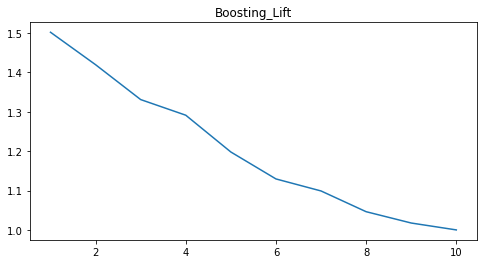

In [46]:
boost=AdaBoostClassifier(base_estimator = LogisticRegression(class_weight='balanced'), algorithm = 'SAMME.R', n_estimators=10)
boost.fit(X_train, y_train)

y_pred_df = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob': boost.predict_proba(X_test)[:,1]})

sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values('predicted_prob',ascending=False)

num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_df = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_df.columns = ['decile','gain']

gain_lift_df['gain__percetage']= (100* gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df['lift']= (gain_lift_df.gain__percetage/(gain_lift_df.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_df['decile'],
         gain_lift_df['lift'],'-')
plt.title('Boosting_Lift')
plt.show()

number of observations per decile: 1184


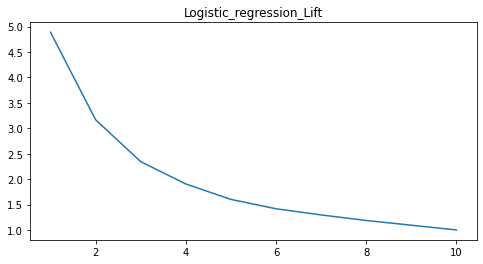

In [47]:
LR=LogisticRegressionCV(class_weight='balanced')
LR.fit(X_train, y_train)

y_pred_df = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob': LR.predict_proba(X_test)[:,1]})

sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values('predicted_prob',ascending=False)

num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_df = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_df.columns = ['decile','gain']

gain_lift_df['gain__percetage']= (100* gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df['lift']= (gain_lift_df.gain__percetage/(gain_lift_df.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_df['decile'],
         gain_lift_df['lift'],'-')
plt.title('Logistic_regression_Lift')
plt.show()

<div class="alert alert-block alert-danger" >
From the plot we can observe the following:
    
b. RandomForest gives highest lift in the top decile
     
c. RandomForest gives best lift in the top quartile

### What feature selection techniques could be used to reduce the number of features? What other feature selection techniques could be used in this scenario?

<div class="alert alert-block alert-danger" >
`We could use Chi-Square_test,Correlation_coefficients, Variance threshold, Mean Absolute Difference, Forward feature selction, Backward feature elimination, reccursive feature elemination.`

`We could also use Lasso Regularization or Random forest feature importance`

**Example**

In [43]:
df_corr=X_train.copy()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
print(f' With correlation greater than 0.8 we can drop {len(to_drop)} highly correlated features and reduce features and data redundancy')

 With correlation greater than 0.8 we can drop 240 highly correlated features and reduce features and data redundancy


or get top 20 features by randomforest feature importance

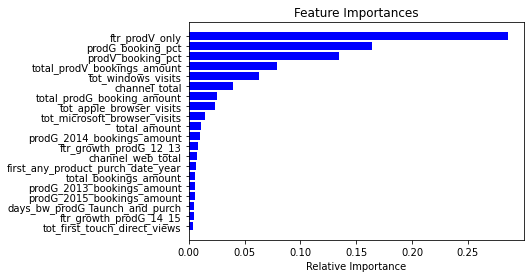

In [49]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [46]:
df_train[df_train['ftr_prodV_only']==0][response_variable].value_counts(normalize=True)

1    0.553315
0    0.446685
Name: trainy_period_workstation_purchase_flag, dtype: float64

**The most important feature when respose variable is 0 contains 55% 1 and 44% times 0**

In [45]:
df_train[df_train['ftr_prodV_only']==1][response_variable].value_counts()

0    71988
Name: trainy_period_workstation_purchase_flag, dtype: int64

**The most important feature when respose variable is 1 contains only records classified as 0 for the feature 'ftr_prodV_only which is classified as the most important variable under RF model**

In [37]:
df_train.groupby(['total_prodV_bookings_amount'])[response_variable].value_counts()

total_prodV_bookings_amount  trainy_period_workstation_purchase_flag
-1294.85                     0                                          1
-439.50                      0                                          1
-286.00                      0                                          1
-230.58                      0                                          1
-200.00                      0                                          1
                                                                       ..
 61158.15                    1                                          1
 129496.82                   0                                          1
 189925.80                   0                                          1
 3958462.06                  1                                          1
 7745657.81                  1                                          1
Name: trainy_period_workstation_purchase_flag, Length: 10896, dtype: int64

In [50]:
imp_features=[features[i] for i in indices]

In [51]:
imp_features

['tot_first_touch_direct_views',
 'ftr_growth_prodG_14_15',
 'days_bw_prodG_launch_and_purch',
 'prodG_2015_bookings_amount',
 'prodG_2013_bookings_amount',
 'total_bookings_amount',
 'first_any_product_purch_date_year',
 'channel_web_total',
 'ftr_growth_prodG_12_13',
 'prodG_2014_bookings_amount',
 'total_amount',
 'tot_microsoft_browser_visits',
 'tot_apple_browser_visits',
 'total_prodG_booking_amount',
 'channel_total',
 'tot_windows_visits',
 'total_prodV_bookings_amount',
 'prodV_booking_pct',
 'prodG_booking_pct',
 'ftr_prodV_only']

The above Features will be used in our modelling from henceforth

### Modeling Technique


<div class="alert alert-block alert-danger" >
The main difference between random forests and gradient boosting lies in how the decision trees are created and aggregated. Unlike random forests, the decision trees in gradient boosting are built additively; in other words, each decision tree is built one after another.

However, these trees are not being added without purpose. Each new tree is built to improve on the deficiencies of the previous trees and this concept is called boosting.

The gradient part of gradient boosting comes from minimising the gradient of the loss function as the algorithm builds each tree.

Another key difference between random forests and gradient boosting is how they aggregate their results. In random forests, the results of decision trees are aggregated at the end of the process. Gradient boosting doesn’t do this and instead aggregates the results of each decision tree along the way to calculate the final result.

Overall, gradient boosting usually performs better than random forests but they’re prone to overfitting; to avoid this, we need to remember to tune the parameters carefully.

* max_depth='None'
* n_estimators=200

In other words, the most ideal random forest model for this training set contains 200 decision trees with a maximum depth of 'None'.

In [58]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 200, max_depth =None, random_state = 10,class_weight='balanced_subsample')
# Fit model
start = time.time()
rf_model = rf.fit(X_train[imp_features],y_train)
end = time.time()
fit_time = end - start
# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test[imp_features])
probas=rf.predict_proba(X_test[imp_features])[:,1]
auc_score = roc_auc_score(y_test, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_test).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 11.681 / Predict time: 0.356
Precision: 0.891 / Recall: 0.63 / Accuracy: 0.979
AUC: 0.99


**Training accuracy is as seen above**

In [59]:
# Predict on scoring set
start = time.time()
Y_pred = rf_model.predict(X_score[imp_features])
probas=rf.predict_proba(X_score[imp_features])[:,1]
auc_score = roc_auc_score(y_score, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_score, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_score).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 11.681 / Predict time: 1.003
Precision: 0.911 / Recall: 0.766 / Accuracy: 0.988
AUC: 1.0


**scoring accuracy is as above, we have good AUC with the scoring data**

<AxesSubplot:>

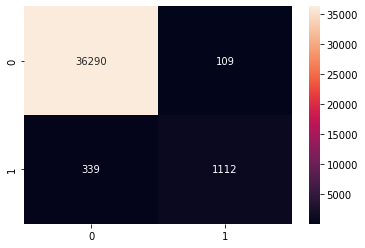

In [68]:
# Confusion matrix for GradientBoostingClassifier
import seaborn as sns
matrix = confusion_matrix(y_score, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

In [71]:
# Instantiate GradientBoostingClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250, max_depth = 3, learning_rate = 0.01, random_state = 42)
# Fit model
start = time.time()
rf_model = rf.fit(X_train[imp_features],y_train)
end = time.time()
fit_time = end - start
# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test[imp_features])
probas=rf.predict_proba(X_test[imp_features])[:,1]
auc_score = roc_auc_score(y_test, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_test).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 24.502 / Predict time: 0.059
Precision: 0.89 / Recall: 0.533 / Accuracy: 0.975
AUC: 0.99


In [72]:
# Predict on scoring set
start = time.time()
Y_pred = rf_model.predict(X_score[imp_features])
probas=rf.predict_proba(X_score[imp_features])[:,1]
auc_score = roc_auc_score(y_score, probas)
auc = round(auc_score, 2)
end = time.time()
pred_time = end - start
# Time and prediction results
precision, recall, fscore, support = precision_recall_fscore_support(y_score, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==y_score).sum() / len(Y_pred), 3)}")
print(f"AUC: {auc}")

Fit time: 24.502 / Predict time: 0.193
Precision: 0.923 / Recall: 0.703 / Accuracy: 0.986
AUC: 1.0


scoring accuracy is as above, we have good AUC with the scoring data 


How could clustering be combined with classification for this problem?

#### 
<div class="alert alert-block alert-danger" >
Clustering is a type of unsupervised machine learning which aims to find homogeneous subgroups such that objects in the same group (clusters) are more similar to each other than the others.

KMeans is a clustering algorithm which divides observations into k clusters. Since we can dictate the amount of clusters, it can be easily used in classification where we divide data into clusters which can be equal to or more than the number of classes.

`In the VMWare dataset which is a collection of labelled workstations purchase flags, we can use KMeans to find clusters within the dataset and test how good it is as a feature`

`Clustering apart from being an unsupervised machine learning can also be used to create clusters as features to improve classification models. On their own they aren’t enough for classification. But when used as features they improve model accuracy.`

In [109]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Predicting only K-Means Clustering

In [98]:
clust(X_train,X_score,y_train,y_score).Kmeans(output='replace').classify(model=RandomForestClassifier(n_estimators = 200, max_depth =None, random_state = 10,class_weight='balanced_subsample'))
# Fit model)

Accuracy: 0.816221928665786
AUC: 0.53


### Predicting without using K-Means Clustering using Logistics Regression

In [110]:
clust(X_train[imp_features],X_score[imp_features],y_train,y_score).classify()

Accuracy: 0.829881109643329
AUC: 0.88


### Predicting using K-Means Clustering and Logistics Regression

In [111]:
clust(X_train[imp_features],X_score[imp_features],y_train,y_score).Kmeans(output='add').classify()

Accuracy: 0.8964861294583883
AUC: 0.95


`Clustering apart from being an unsupervised machine learning can also be used to create clusters as features to improve classification models. On their own they aren’t enough for classification as the results show. But when used as features they improve model accuracy.`


## 	What value of regularization parameter leads to the best results for penalized logistic regression?

In [52]:
from sklearn.model_selection import KFold
# Make a list of 6 C values to vary the range of regularization such that you get the best accuracy
Clist = [1e-30,1e-20,1e-17,1e-15,1e-5,1e-3,1,1e3,1e5]

# Create a dictionary to store the validation acurracies of corresponding c values
validation_accuracy = {}

for i in Clist:
    cross_validation_score = []

    # Specifying the number of splits needed
    kf = KFold(n_splits=5)

    # Getting the split indices iteratively
    for train_index , val_index in kf.split(X_train_std):

        # Getting the cross-validation train and val data using the indies
        X_train_cross , X_val_cross = X_train_std[train_index,:],X_train_std[val_index,:]
        y_train_std_cross , y_val_cross = y_train_std[train_index] , y_train_std[val_index]

        # Making a logistic regression model
        lr_l2 = LogisticRegression(C=i, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')

        # Fitting the model
        lr_l2.fit(X_train_cross,y_train_std_cross)

        # Predicting on val data and storing the accuracy
        y_val_pred = lr_l2.predict(X_val_cross)
        cross_validation_score.append(accuracy_score(y_val_cross, y_val_pred))
    
    # Storing the accuracy corresponding to every c-value 
    validation_accuracy[i] = np.mean(cross_validation_score)

# Calculating the best value of c
best_c = max(validation_accuracy.items(), key=lambda x: x[1])[0]
print(f'The best regularization parameter C is {best_c}')

The best regularization parameter C is 1000.0


<div class="alert alert-block alert-danger" >

The best regularization parameter C is 1000.0

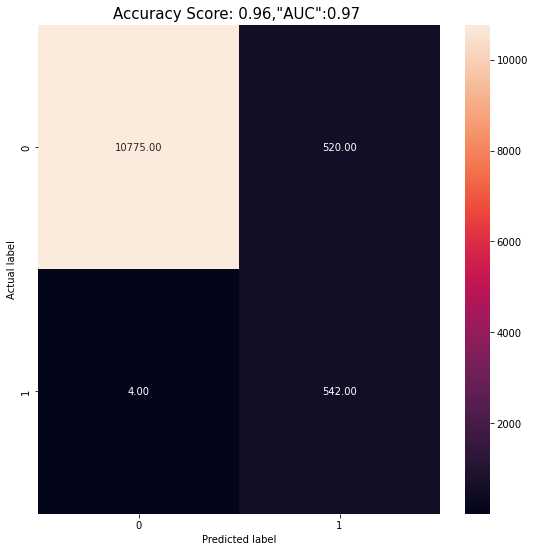

In [69]:
# Training the best model
lr_best = LogisticRegression(C=best_c, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')
lr_best.fit(X_train_std, y_train_std)
y_pred_test = lr_best.predict(X_test_std)
logreg_best_auc = roc_auc_score(y_test,y_pred_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title(f'Accuracy Score: {round(accuracy_score(y_test,y_pred_test),2)},"AUC":{round(logreg_best_auc,2)} ', size = 15);

## 	How many features have non-zero coefficients when the penalization parameter alpha is set to 0?

setting alpha to 0 is building the model on ridge regularization, which from above penalty=L2 makes it ridge regularization

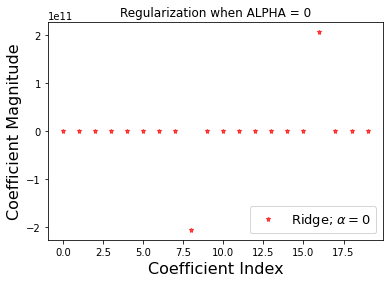

In [61]:
from sklearn.linear_model import Ridge
lr_zero = LogisticRegression(C=1000, max_iter=16000,class_weight='balanced',solver='newton-cg',penalty='l2')
lr_zero.fit(X_train_std, y_train_std)
rr0 = Ridge(alpha=0) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr0.fit(X_train_std, y_train_std)
rr100 = Ridge(alpha=1) #  comparison with alpha value 1
rr100.fit(X_train_std, y_train_std)
train_score=lr_zero.score(X_train_std, y_train_std)
test_score=lr_zero.score(X_test_std, y_test_std)
Ridge_train_score = rr0.score(X_train_std,y_train_std)
Ridge_test_score = rr0.score(X_test_std, y_test_std)
Ridge_train_score100 = rr100.score(X_train_std,y_train_std)
Ridge_test_score100 = rr100.score(X_test_std, y_test_std)
plt.plot(rr0.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0$',zorder=7) 
#plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$') 
#plt.plot(lr_zero.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.title('Regularization when ALPHA = 0')
plt.legend(fontsize=13,loc=4)
plt.show()


<div class="alert alert-block alert-danger" >
`When alpha is 0 we can observe that out of the 20 top important features, there were 2 with non zero coefficients`

## 	What is the answer when the value is set to 1?

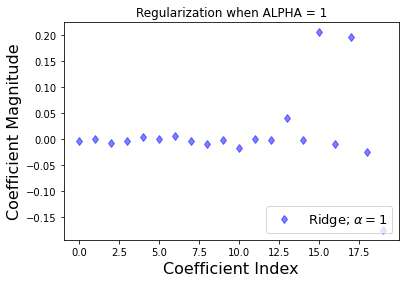

In [62]:
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.title('Regularization when ALPHA = 1')
plt.legend(fontsize=13,loc=4)
plt.show()


<div class="alert alert-block alert-danger" >
`When alpha is 1 we can observe that out of the 20 top important features, there were none with non zero coefficients`

## 	One more way to compare regularized vs. normal logistic regression is to look at the values of the coefficients. Can you compare the values at each decile for a normal and regularized logistic regression?

We will generate a normal logictics to compare with the best model genereated above 

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none') 0.65


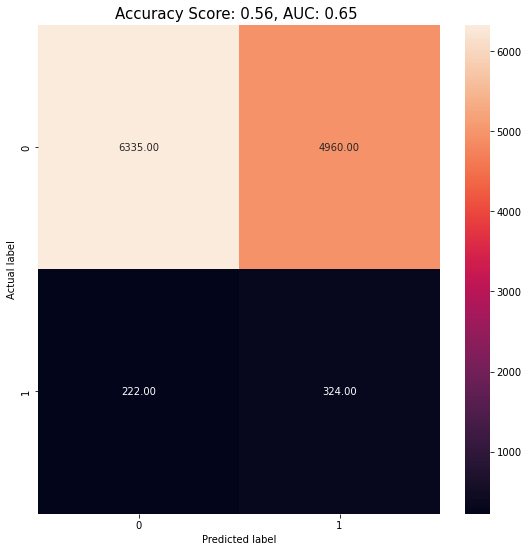

In [88]:
# Fit a vanilla Logistic Regression classifier and make predictions
lr_normal = LogisticRegression(max_iter=1000, penalty='none',class_weight='balanced')
lr_normal.fit(X_train[imp_features], y_train)
y_pred_test = lr_normal.predict(X_test[imp_features])
probas_normal = lr_normal.predict_proba(X_test[imp_features])[:,1]
lr_normal_auc = round(roc_auc_score(y_test, probas_normal),2)

print(lr_normal,lr_normal_auc)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title(f'Accuracy Score: {round(accuracy_score(y_test,y_pred_test),2)}, AUC: {lr_normal_auc} ', size = 15);

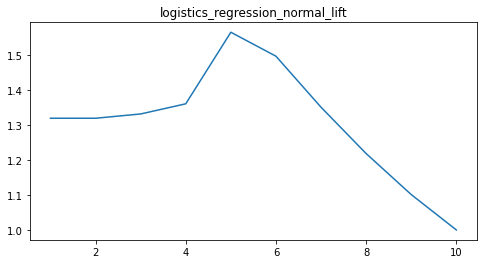

In [176]:


y_pred_df_normal = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob_lr_normal': lr_normal.predict_proba(X_test[imp_features])[:,1]})

sorted_predict_df = y_pred_df_normal[['predicted_prob_lr_normal','actual']].sort_values('predicted_prob_lr_normal',ascending=False)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_lr_normal = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_lr_normal.columns = ['decile','gain']

gain_lift_lr_normal['gain__percetage']= (100* gain_lift_lr_normal.gain.cumsum()/gain_lift_lr_normal.gain.sum())
gain_lift_lr_normal['lift']= (gain_lift_lr_normal.gain__percetage/(gain_lift_lr_normal.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_lr_normal['decile'],
         gain_lift_lr_normal['lift'],'-')
plt.title('logistics_regression_normal_lift')
plt.show()

In [163]:
num_per_decile = int(len(sorted_predict_df)/10)
print('number of observations per decile:' , num_per_decile)

number of observations per decile: 1184


In [164]:
print(f' Total records in our data is {X_test.shape[0]//10*10}')

 Total records in our data is 11840


In [165]:
y_test.value_counts()[1]

546

`We have 546 buyers of workstation in our test data` 

In [180]:
gain_lift_lr_normal['No_of_observations']=[int(x) for x in list(np.linspace(0, X_test.shape[0], 10+1)[1:])] #10 because decile +1 for explicit pos argument
gain_lift_lr_normal['No_of_WS_buyers_without_model']=[int(x) for x in list(np.linspace(0, y_test.value_counts()[1], 10+1)[1:])]
gain_lift_lr_normal.rename(columns={'gain':'No_of_WS_buyers_using_model'},inplace=True)
gain_lift_lr_normal['CumSum_positives_using_the_model']=gain_lift_lr_normal.No_of_WS_buyers_using_model.cumsum()
rearrange_gain_lift_df_col=['decile', 'No_of_observations', 'No_of_WS_buyers_without_model', 'No_of_WS_buyers_using_model','CumSum_positives_using_the_model','gain__percetage', 'lift']

In [182]:
gain_lift_lr_normal[rearrange_gain_lift_df_col]

,decile,No_of_observations,No_of_WS_buyers_without_model,No_of_WS_buyers_using_model,CumSum_positives_using_the_model,gain__percetage,lift
0,1,1184,54,72,72,13.186813,1.318681
1,2,2368,109,72,144,26.373626,1.318681
2,3,3552,163,74,218,39.926740,1.330891
3,4,4736,218,79,297,54.395604,1.359890
4,5,5920,273,130,427,78.205128,1.564103
5,6,7104,327,63,490,89.743590,1.495726
6,7,8288,382,26,516,94.505495,1.350078
7,8,9472,436,16,532,97.435897,1.217949
8,9,10656,491,9,541,99.084249,1.100936
9,10,11841,546,5,546,100.000000,1.000000


<div class="alert alert-block alert-danger" >
From above we can observe that the from the **Normal Logistics regression model** we can reach 490 customers buying the workstation within the 5th decile while it would take upto the 9th decile for 490 customers to buy workstation  

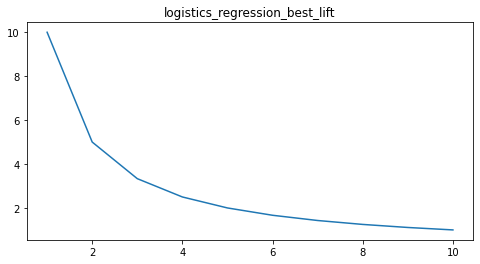

In [197]:
y_pred_df_best = pd.DataFrame({'actual' : y_test ,
                          'predicted_prob_lr_best': lr_best.predict_proba(X_test_std)[:,1]})

sorted_predict_df = y_pred_df_best[['predicted_prob_lr_best','actual']].sort_values('predicted_prob_lr_best',ascending=False)

deciles_predicted_df = get_deciles(sorted_predict_df)

gain_lift_lr_best = pd.DataFrame(
        deciles_predicted_df.groupby('decile')['actual'].sum()).reset_index()
gain_lift_lr_best.columns = ['decile','gain']

gain_lift_lr_best['gain__percetage']= (100* gain_lift_lr_best.gain.cumsum()/gain_lift_lr_best.gain.sum())
gain_lift_lr_best['lift']= (gain_lift_lr_best.gain__percetage/(gain_lift_lr_best.decile *10))

import matplotlib.pyplot as plt
plt.figure(figsize =(8,4))
plt.plot(gain_lift_lr_best['decile'],
         gain_lift_lr_best['lift'],'-')
plt.title('logistics_regression_best_lift')
plt.show()

In [198]:
gain_lift_lr_best['No_of_observations']=[int(x) for x in list(np.linspace(0, X_test.shape[0], 10+1)[1:])] #10 because decile +1 for explicit pos argument
gain_lift_lr_best['No_of_WS_buyers_without_model']=[int(x) for x in list(np.linspace(0, y_test.value_counts()[1], 10+1)[1:])]
gain_lift_lr_best.rename(columns={'gain':'No_of_WS_buyers_using_model'},inplace=True)
gain_lift_lr_best['CumSum_positives_using_the_model']=gain_lift_lr_best.No_of_WS_buyers_using_model.cumsum()
rearrange_gain_lift_df_col=['decile', 'No_of_observations', 'No_of_WS_buyers_without_model', 'No_of_WS_buyers_using_model','CumSum_positives_using_the_model','gain__percetage', 'lift']

In [199]:
gain_lift_lr_best[rearrange_gain_lift_df_col]

,decile,No_of_observations,No_of_WS_buyers_without_model,No_of_WS_buyers_using_model,CumSum_positives_using_the_model,gain__percetage,lift
0,1,1184,54,546,546,100.0,10.000000
1,2,2368,109,0,546,100.0,5.000000
2,3,3552,163,0,546,100.0,3.333333
3,4,4736,218,0,546,100.0,2.500000
4,5,5920,273,0,546,100.0,2.000000
5,6,7104,327,0,546,100.0,1.666667
6,7,8288,382,0,546,100.0,1.428571
7,8,9472,436,0,546,100.0,1.250000
8,9,10656,491,0,546,100.0,1.111111
9,10,11841,546,0,546,100.0,1.000000


<div class="alert alert-block alert-danger" >
From above we can observe that the from the **Rgularized Logistics regression model** we can reach all the 546 customers buying the workstation within the 1st decile itself.Showing us the regularization works well for for dataset

#### Comparing values of coeffecients

In [207]:
#make a dictionary of the coefficients along with the predictors as keys

lreg_best_coef = dict(zip(X_train[imp_features].columns, np.transpose(lr_best.coef_)))

#Linear regression coefficient values to plot

lreg_reg_x = list(lreg_best_coef.keys())
lreg_reg_y = list(lreg_best_coef.values())

In [208]:
#make a dictionary of the coefficients along with the predictors as keys
lreg_normal_coef = dict(zip(X_train[imp_features].columns, np.transpose(lr_normal.coef_)))

#Linear regression coefficient values to plot

lreg_normal_x = list(lreg_normal_coef.keys())
lreg_normal_y = list(lreg_normal_coef.values())

Normal linear regression coeeficients Max and Min

In [227]:
min([float(x) for x in lreg_normal_y]),max([float(x) for x in lreg_normal_y])

(-6.512705361409642e-15, 6.09929847446008e-10)

Max coefficient for normal logistics regression is 6*10^-10 a very small coeffecient

Regularized linear regression coeeficients: Max and Min

In [224]:
min([float(x) for x in lreg_reg_y]),max([float(x) for x in lreg_reg_y])

(-5.248958713047074, 1.3258572106754494)

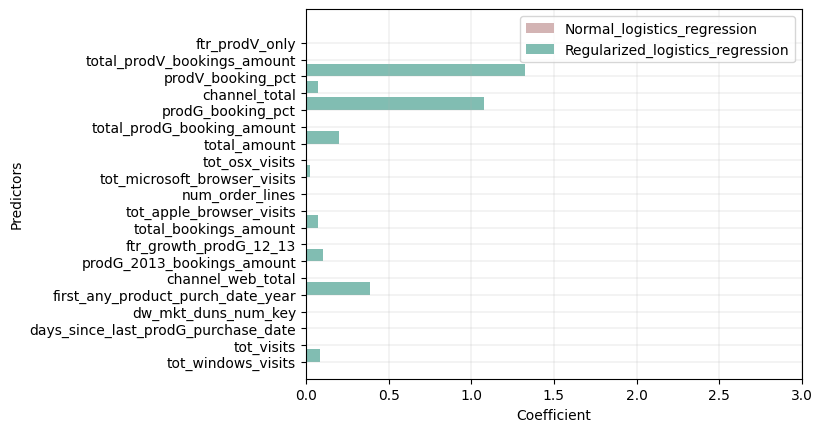

In [226]:
plt.rcdefaults()

plt.barh(lreg_normal_x,[float(x) for x in lreg_normal_y],1.0, align='edge',color="#D3B4B4", label="Normal_logistics_regression")
plt.barh(lreg_reg_x,[float(x) for x in lreg_reg_y],0.75 ,align='edge',color="#81BDB2",label = "Regularized_logistics_regression")

plt.grid(linewidth=0.2)
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.legend(loc='best')
plt.xlim(-6.5e-15,3)
plt.show()

### Comparing AUC of Normal LR and Regularized Logistics regression

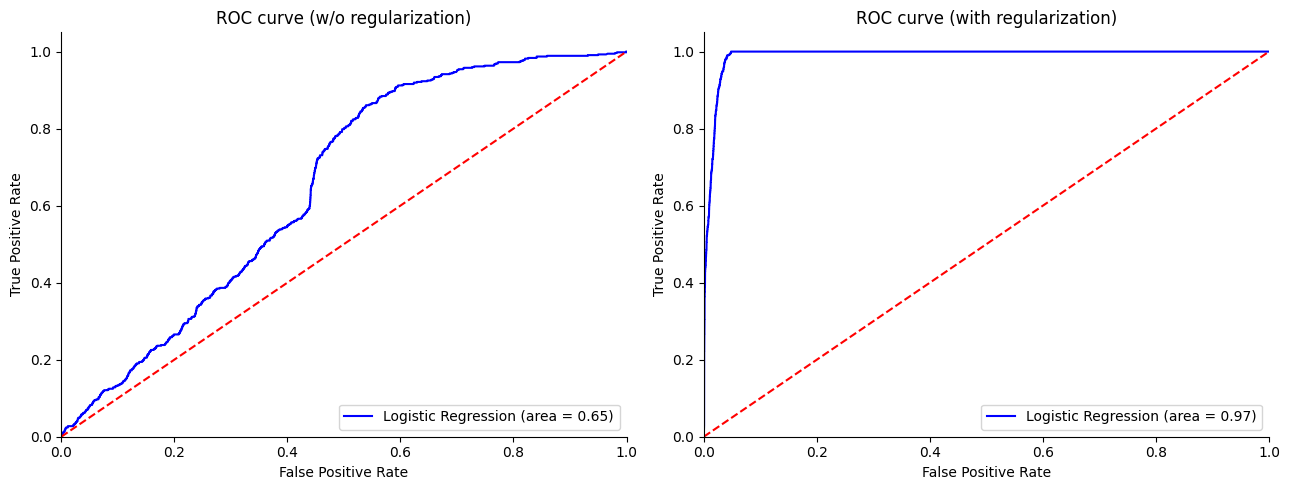

In [231]:
fig, ax = plt.subplots(1, 2, figsize = (13,5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)

# Plotting the ROC curve for logistic regression without regularization
y_probs = lr_normal.predict_proba(X_test[imp_features])[:,1]
plot_roc(y_test,y_probs,lr_normal_auc,ax[0])
ax[0].set_title('ROC curve (w/o regularization)')

# Plotting the ROC curve for logistic regression with regularization
y_probs_best = lr_best.predict_proba(X_test_std)[:,1]
plot_roc(y_test,y_probs_best,logreg_best_auc,ax[1])
ax[1].set_title('ROC curve (with regularization)')
plt.tight_layout()

# What other methods can be used to handle imbalanced datasets such as this one?

**Random Under-Sampling**
- Random Undersampling aims to balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out.

**Random Over-Sampling**
- Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.

**Cluster-Based Over Sampling**
In this case, the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.  

**Informed Over Sampling: Synthetic Minority Over-sampling Technique for imbalanced data (SMOTE)**
- This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.

**Algorithmic Ensemble Techniques**
- The main objective of ensemble methodology is to improve the performance of single classifiers. The approach involves constructing several two stage classifiers from the original data and then aggregate their predictions.

#### Example of few Imbalance Techniques

#### Strategy 1 - Vanilla Random Forest

- No correction for imbalance

In [63]:
# Define a Random Forest classifier with randon_state as above
random_state=22
max_depth=10
# Set the maximum depth to be max_depth and use 10 estimators
random_forest = RandomForestClassifier(max_depth=2, random_state=22, n_estimators=5)

# Fit the model on the training set
random_forest.fit(X_train[imp_features], y_train)


RandomForestClassifier(max_depth=2, n_estimators=5, random_state=22)

In [64]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score1
f_score = f1_score(y_val_test, predictions)
score1 = round(f_score, 2)

# Compute the AUC and assign it to variable auc1
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc1 = round(auc_score, 2)


#### Strategy 2 - Random Forest with class weighting
- Balancing the class imbalance in each bootstrap

In [65]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10,class_weight='balanced_subsample')

# Fit the model on the training se
random_forest.fit(X_train[imp_features], y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=10, random_state=22)

In [66]:
### edTest(test_balanced) ###

# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score2
f_score = f1_score(y_val_test, predictions)
score2 = round(f_score, 2)

# Compute the AUC and assign it to variable auc2
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc2 = round(auc_score, 2)


#### Strategy 3 - Balanced Random Forest with SMOTE 

- Using the **imblearn** `BalancedRandomForestClassifier()` 
- Read more about this implementation [here](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)

In [67]:
# Perform upsampling using SMOTE

# Define a SMOTE with random_state=2
sm = SMOTE(random_state=2)

# Use the SMOTE object to upsample the train data
# You may have to use ravel() 
X_train_res, y_train_res = sm.fit_resample(X_train[imp_features], y_train.ravel())

In [68]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = BalancedRandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10, class_weight='balanced_subsample')

# Fit the Random Forest on upsampled data 
random_forest.fit(X_train_res, y_train_res)

BalancedRandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                               n_estimators=10, random_state=22)

In [69]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute the F1-score and assign it to variable score3
f_score = f1_score(y_val_test, predictions)
score3 = round(f_score, 2)

# Compute the AUC and assign it to variable auc3
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc3 = round(auc_score, 2)

#### Strategy 4 - Downsample the data

Using the imblearn RandomUnderSampler().

In [70]:
# Define an RandomUnderSampler instance with random state as 2
rs = RandomUnderSampler(random_state=2)

# Downsample the train data
# You may have to use ravel()
X_train_res, y_train_res = rs.fit_resample(X_train[imp_features], y_train.ravel())


In [71]:
# Define a Random Forest classifier with randon_state as above
# Set the maximum depth to be max_depth and use 10 estimators
# Use class_weight as balanced_subsample to weigh the class accordingly
random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=10,class_weight='balanced_subsample')

# Fit the Random Forest on downsampled data 
random_forest.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=10, random_state=22)

In [72]:
# Use the trained model to predict on the validation set 
predictions = random_forest.predict(X_val_test[imp_features])

# Compute two metrics that better represent misclassification of minority classes 
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score4
f_score = f1_score(y_val_test, predictions)
score4 = round(f_score, 2)

# Compute the AUC and assign it to variable auc4
probas = random_forest.predict_proba(X_val_test[imp_features])[:,1]
auc_score = roc_auc_score(y_val_test, probas)
auc4 = round(auc_score, 2)

In [73]:
# Compile the results from the implementations above

pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score"]
pt.add_row(["Random Forest - No imbalance correction",score1,auc1])
pt.add_row(["Random Forest - balanced_subsamples",score2,auc2])
pt.add_row(["Random Forest - Upsampling",score3,auc3])
pt.add_row(["Random Forest - Downsampling",score4,auc4])
print(pt)


+-----------------------------------------+----------+-----------+
|                 Strategy                | F1 Score | AUC score |
+-----------------------------------------+----------+-----------+
| Random Forest - No imbalance correction |   0.0    |    0.97   |
|   Random Forest - balanced_subsamples   |   0.78   |    0.98   |
|        Random Forest - Upsampling       |   0.77   |    0.98   |
|       Random Forest - Downsampling      |   0.76   |    0.97   |
+-----------------------------------------+----------+-----------+


<div class="alert alert-block alert-danger" >
When faced with imbalanced data sets there is no one stop solution to improve the accuracy of the prediction model.  One may need to try out multiple methods to figure out the best-suited sampling techniques for the dataset. In most cases, synthetic techniques like SMOTE and MSMOTE will outperform the conventional oversampling and undersampling methods.

For better results, one can use synthetic sampling methods like SMOTE and MSMOTE along with advanced boosting methods like Gradient boosting and XG Boost.

One of the advanced bagging techniques commonly used to counter the imbalanced dataset problem is SMOTE bagging. It follows an entirely different approach from conventional bagging to create each Bag/Bootstrap. It generates the positive instances by the SMOTE Algorithm by setting a SMOTE resampling rate in each iteration. The set of negative instances is bootstrapped in each iteration.

Depending on the characteristics of the imbalanced data set, the most effective techniques will vary. Relevant evaluation parameters should be considered during the model comparison.

While comparing multiple prediction models built through an exhaustive combination of the above-mentioned techniques Lift & Area under the ROC Curve will be instrumental in determining which model is superior to the others.

# Communicating results to business

### how should the lift values be communicated to the business?

<div class="alert alert-block alert-danger" >
The lift could be interpreted as the gain ratio percentage to the random percentage at a given decile level. In a layman term, in decile 1, we have 10 means that when selecting 10% of the data based on the model, we could find the target (actual positive) 10 times more than the randomly selected 10% of the data without a model.

# Few uses of the propensity model in an online store.How can the model be white-boxed to explain the importance of various features in the model?

<div class="alert alert-block alert-danger" >
    
Propensity modeling attempts to predict the likelihood that visitors, leads, and customers will perform certain actions. It’s a statistical approach that accounts for all the independent and confounding variables that affect said behavior.

So, for example, propensity modeling can help a marketing team predict the likelihood that a lead will convert to a customer. Or that a customer will churn. Or even that an email recipient will unsubscribe.

The propensity score, then, is the probability that the visitor, lead, or customer will perform a certain action. 


The first step is to actually pick a model because you have a few options. For example, instead of measuring propensity to churn, you could choose a survival analysis.

Regression is a good option because it’s very interpretable for non-technical audiences, which means it can be communicated easily.

It’s also less of a black box, making the risk more manageable. If something goes wrong and accuracy is low or you get an unexpected result, it’s easy to drill down to the formula and figure out how to fix it.